### British Airways Reviews & Text Analysis

In [ ]:
# 1. Importing required libraries
import pandas as pd
import numpy as np
%load_ext sql
import pyodbc
import  matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import re 
import nltk 
from nltk.corpus import stopwords 
from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

In [59]:
# 2. Loading the SQL query in Python and converting dataset into a DataFrame
conn = pyodbc.connect(r"DRIVER={ODBC Driver 17 for SQL Server};" r"SERVER=PARIKSHITA-COMP\SQLEXPRESS;" r"DATABASE=PortfolioProjects;" r"Trusted_Connection=yes;")
cursor = conn.cursor().execute("select [Seat Comfort],[Cabin Staff Service],[Food & Beverages],[Inflight Entertainment],[Ground Service],[Value For Money],[Wifi & Connectivity] from PortfolioProjects..british_airways_review") 
query2 = cursor.fetchall()
conn.close()
rating_df = pd.DataFrame.from_records(query2,columns = ['Seat Comfort','Cabin Staff Service','Food & Beverages','Inflight Entertainment','Ground Service','Value For Money','Wifi & Connectivity'])

In [80]:
rating_df_avg = rating_df.mean()
rating_df_avg = rating_df_avg.reset_index()
rating_df_avg.columns = ['Category','Average Rating']
rating_df_avg

,Category,Average Rating
0,Seat Comfort,2.856985
1,Cabin Staff Service,3.236173
2,Food & Beverages,2.700509
3,Inflight Entertainment,2.642941
4,Ground Service,2.772865
5,Value For Money,2.663023
6,Wifi & Connectivity,1.920123


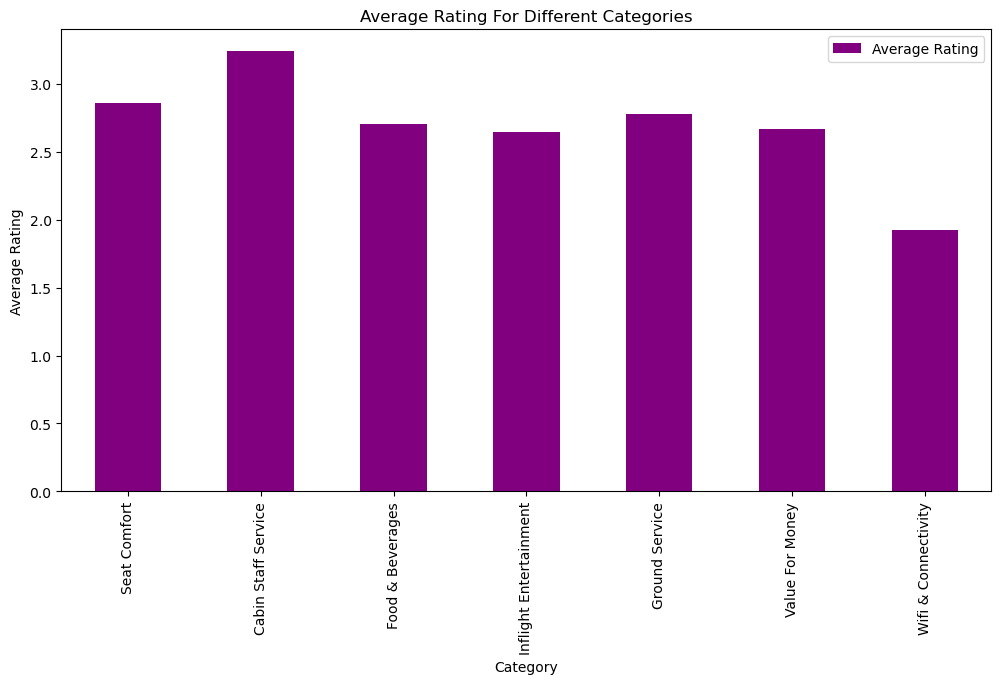

In [85]:
ax = rating_df_avg.plot(kind='bar', x='Category', y= 'Average Rating',figsize=(12,6),color='Purple')
plt.title('Average Rating For Different Categories')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.show()

In [48]:
# 4. Loading the SQL query in Python and converting dataset into a DataFrame
conn = pyodbc.connect(r"DRIVER={ODBC Driver 17 for SQL Server};" r"SERVER=PARIKSHITA-COMP\SQLEXPRESS;" r"DATABASE=PortfolioProjects;" r"Trusted_Connection=yes;")
cursor = conn.cursor().execute("""select main_text
FROM PortfolioProjects..british_airways_review
where main_text not like '%British Airways customer review%'""") 
query1 = cursor.fetchall()
conn.close()
main_textdf = pd.DataFrame.from_records(query1,columns = ['Text'])

#### Data Cleaning (Reviews)

In [49]:
# 5. Text Cleaning Function
pd.set_option('display.max_rows', 100)
def clean_text(text):
    text = text.lower() #convert to lower case
    text = re.sub(r'\W+',' ',text) # removing special characters
    cleaned_words = []

    for word in text.split():      
       if word not in stopwords.words('english'):
          cleaned_words.append(word) #removing words like(eg: is,and,the,etc)
           
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

main_textdf['cleaned_text'] = main_textdf['Text'].apply(clean_text) # Calling the function using the dataset

 #### Word Frequency Analysis

In [50]:
# 6. Tokenization, i.e converting each string into list of words
main_textdf["Tokens"] = main_textdf["cleaned_text"].apply(word_tokenize)

In [51]:
# 7. Word Frequency Analysis
#For all the words in each list, those words are converted to indivdual items and its frequency is known using the 'Counter' class imported from the Collections module
all_words = []
for tokens in main_textdf['Tokens']:
    for word in tokens:
        all_words.append(word)
word_freq = Counter(all_words)
freq_word_df = pd.DataFrame(word_freq.items(),columns = ['word','count'])
freq_word_df_desc = freq_word_df.reset_index()
freq_word_df_desc.sort_values(by='count', ascending=False, inplace=True)
freq_word_df_desc_filter = freq_word_df_desc.set_index('word',inplace=False)
freq_word_df_desc_filter1 = freq_word_df_desc_filter.drop(['british','airways','customer','review','service','ba','flight','crew','experience','airline','flight','crew','cabin','seats','food','seats'],axis=0)
freq_word_df_desc_filter1 = freq_word_df_desc_filter1.reset_index()

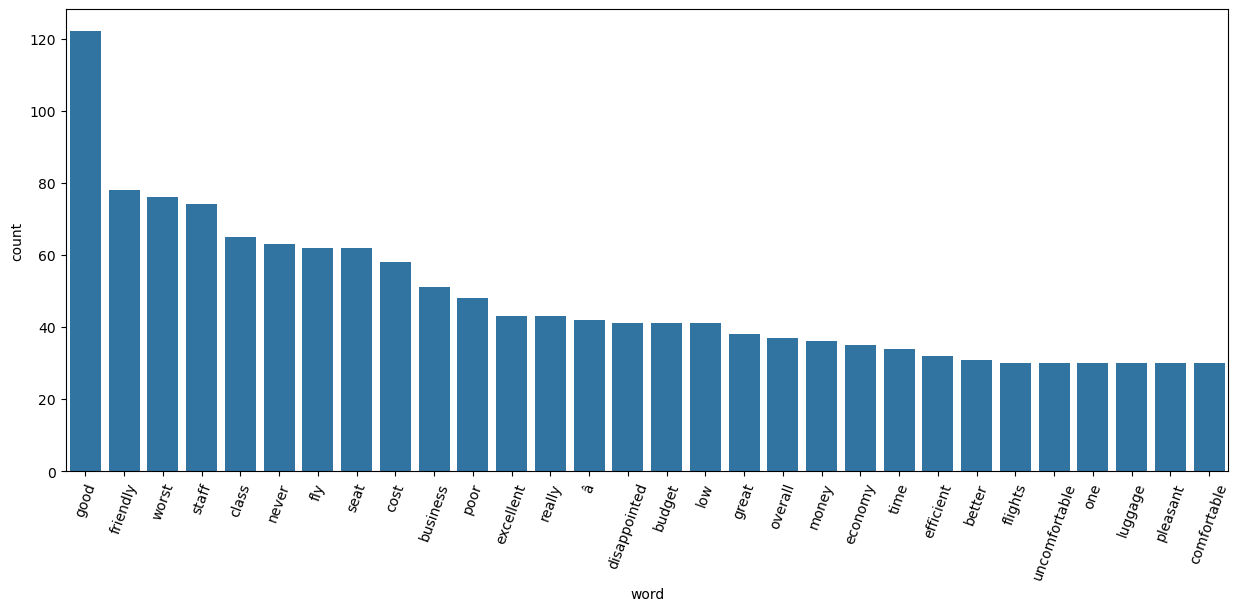

In [52]:
# 8. Word Frequency Visualization
plt.figure(figsize = (15,6))
sns.barplot(x=freq_word_df_desc_filter1['word'][:30],y=freq_word_df_desc_filter1['count'][:30])
plt.xticks(rotation=70)
plt.show()

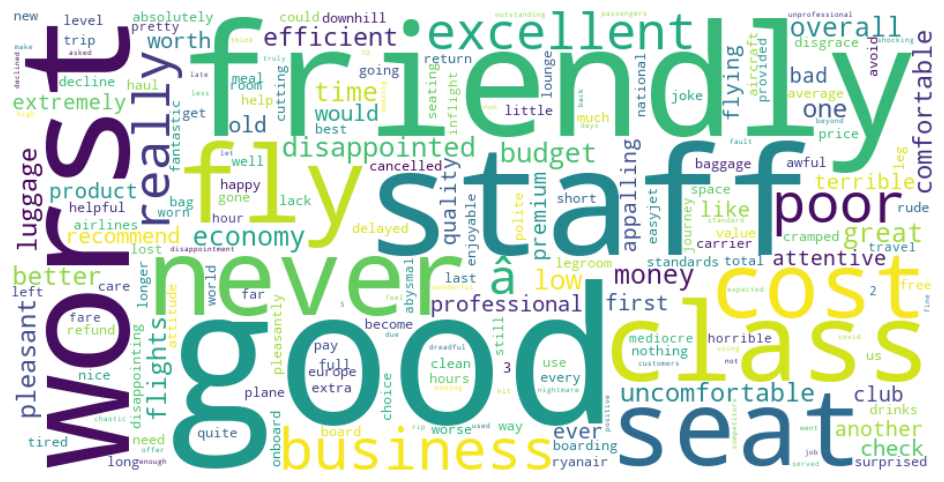

In [53]:
# 9. WordCloud Visualization
word_freq_dict = dict(zip(freq_word_df_desc_filter1['word'], freq_word_df_desc_filter1['count']))

# Generating word cloud using word frequencies
wordcloud = WordCloud(
    width=800, 
    height=400, 
    max_words=200, 
    background_color='white'
).generate_from_frequencies(word_freq_dict) 

# Displaying the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sentiment Analysis

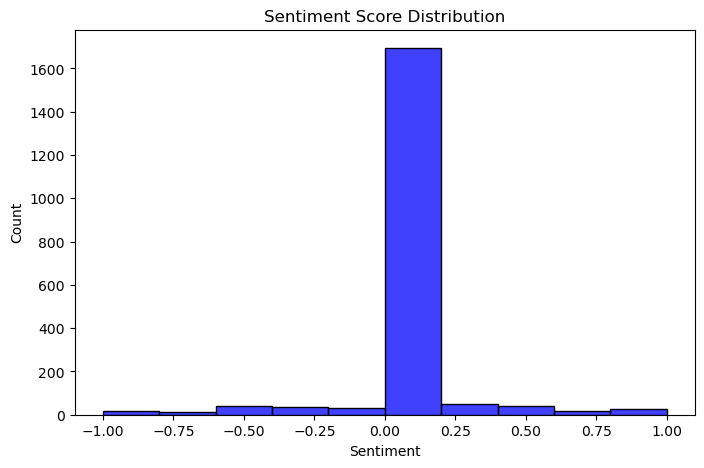

In [54]:
# 10. Sentiment Analysis
freq_word_df["Sentiment"] = freq_word_df["word"].apply(lambda text: TextBlob(text).sentiment.polarity)
plt.figure(figsize=(8,5))
sns.histplot(freq_word_df["Sentiment"], bins=10, color="blue")
plt.title("Sentiment Score Distribution")
plt.show()

### N-gram Analysis

In [58]:
# Creating CountVectorizer for bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = vectorizer.fit_transform(main_textdf['cleaned_text'])

# Sum the frequencies of bigrams
bigram_freq = bigrams.sum(axis=0).A1
bigram_terms = vectorizer.get_feature_names_out()

# Sorting the bigrams by frequency
bigram_freq_sorted = sorted(zip(bigram_terms, bigram_freq), key=lambda x: x[1], reverse=True)

# Printing the sorted bigrams and their frequencies
bigram_freq_df = pd.DataFrame(bigram_freq_sorted, columns=['Bigram', 'Frequency'])
bigram_freq_df.head(5)

,Bigram,Frequency
0,british airways,84
1,customer service,59
2,cabin crew,57
3,business class,38
4,low cost,34


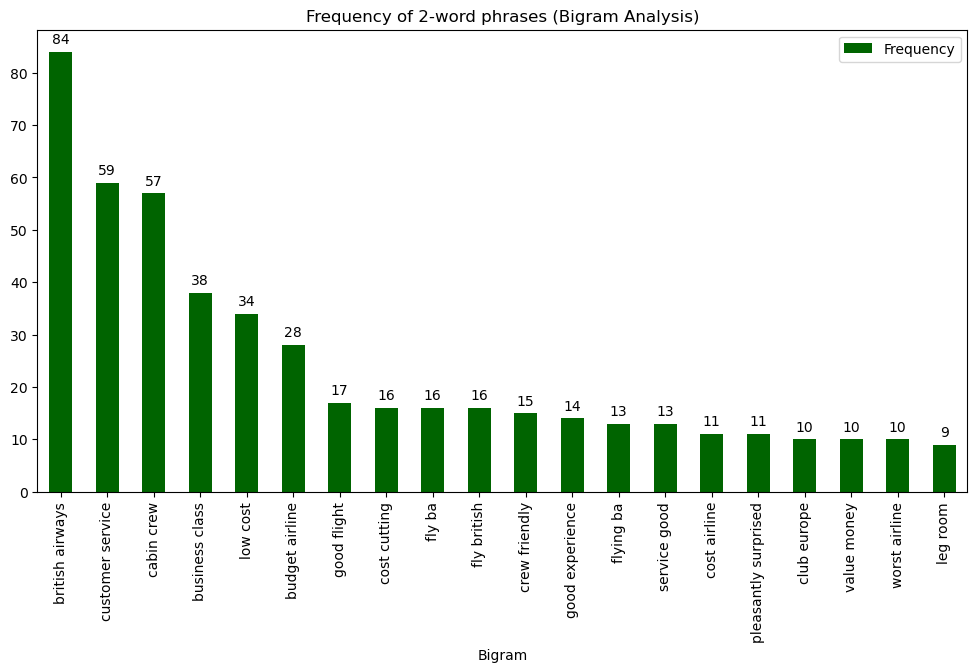

In [92]:
# Visualizing the top 20 Bigrams and their frequency in the reviews
bigram_freq_df_20 = bigram_freq_df.sort_values(by='Frequency', ascending=False).head(20)
ax = bigram_freq_df_20.plot(kind='bar',x='Bigram',y='Frequency',figsize=(12,6),color='darkgreen')
for p in ax.patches:
    # Get the height of each bar (the artwork count)
    height = p.get_height()
    # Get the x-position of the bar (center of the bar)
    x_position = p.get_x() + p.get_width() / 2  
    # Place the text slightly above the bar
    ax.text(x_position, height + 1, str(height), ha='center', va='bottom', fontsize=10, color='black')
plt.title('Frequency of 2-word phrases (Bigram Analysis)')
plt.xticks(rotation=90)
plt.show()

### Time Series Analysis for Review Sentiment Score

In [95]:
# 4. Loading the SQL query in Python and converting dataset into a DataFrame
conn = pyodbc.connect(r"DRIVER={ODBC Driver 17 for SQL Server};" r"SERVER=PARIKSHITA-COMP\SQLEXPRESS;" r"DATABASE=PortfolioProjects;" r"Trusted_Connection=yes;")
cursor = conn.cursor().execute("""select DateConverted, main_text
FROM PortfolioProjects..british_airways_review
where main_text not like '%British Airways customer review%'""") 
query3 = cursor.fetchall()
conn.close()
date_review = pd.DataFrame.from_records(query3,columns = ['Date','Text'])

In [96]:
date_review

,Date,Text
0,2023-04-01,"""found the food menu rather odd"""
1,2023-04-01,"""cover 50% of my new luggage"""
2,2023-04-01,"""the worst flight of my life"""
3,2023-04-01,"""flight was pleasant enough"""
4,2023-04-01,"""downright rude and abusive"""
...,...,...
2851,2015-08-01,"""need to up their game"""
2852,2015-08-01,"""our last flight with British Airways"""
2853,2015-09-01,"""supposed legacy airline"""
2854,2015-08-01,"""staff amiable and present"""


In [97]:
# Function to get sentiment score
def get_sentiment(review):
    return TextBlob(review).sentiment.polarity  # Returns a score between -1 (negative) to +1 (positive)

# Apply sentiment analysis
date_review['sentiment_score'] = date_review['Text'].apply(get_sentiment)
date_review

,Date,Text,sentiment_score
0,2023-04-01,"""found the food menu rather odd""",-0.166667
1,2023-04-01,"""cover 50% of my new luggage""",0.136364
2,2023-04-01,"""the worst flight of my life""",-1.000000
3,2023-04-01,"""flight was pleasant enough""",0.366667
4,2023-04-01,"""downright rude and abusive""",-0.300000
...,...,...,...
2851,2015-08-01,"""need to up their game""",-0.400000
2852,2015-08-01,"""our last flight with British Airways""",0.000000
2853,2015-09-01,"""supposed legacy airline""",0.000000
2854,2015-08-01,"""staff amiable and present""",0.000000


In [101]:
# Average sentiment per day
daily_sentiment = date_review.groupby('Date')['sentiment_score'].mean()
daily_sentiment

Date
2014-12-01   -0.487500
2015-01-01   -0.058929
2015-02-01    0.000000
2015-03-01   -0.275000
2015-04-01    0.177778
                ...   
2024-02-01    0.012821
2024-03-01   -0.054960
2024-04-01   -0.022222
2024-05-01    0.265278
2024-06-01    0.321667
Name: sentiment_score, Length: 114, dtype: float64

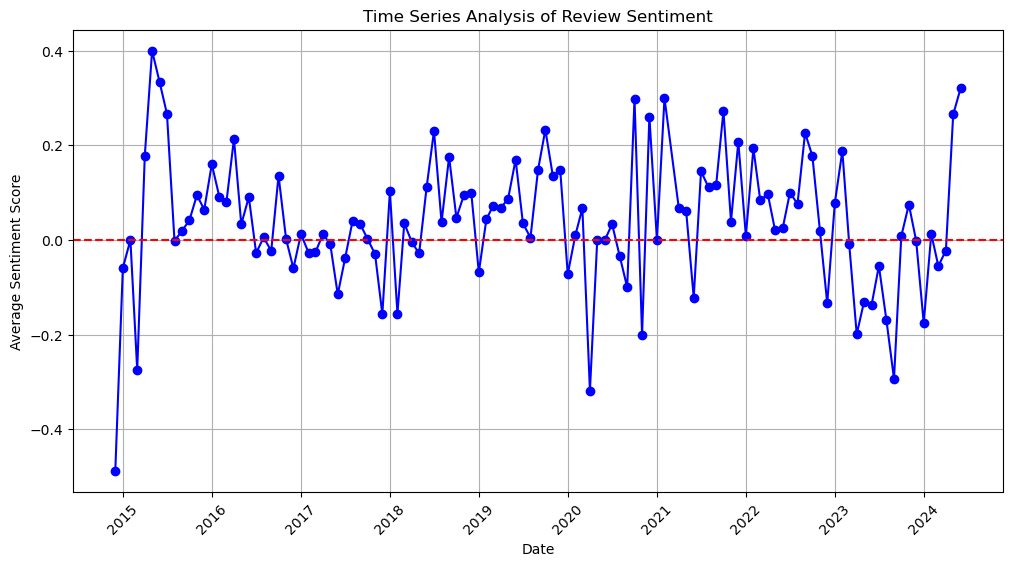

In [105]:
# Plot time series of sentiment scores
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment, marker='o', linestyle='-', color='b')

plt.axhline(y=0, color='red', linestyle='--')  # Neutral sentiment line
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Time Series Analysis of Review Sentiment')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [106]:
print("\nKey Findings:")
print("- Cabin Staff Service has the highest rating with the least for Wifi and Connectivity.")
print("- Common words: Highlighted in bar chart & word cloud.")
print("- Sentiment Analysis: With major Sentiment Score ranging between 0 - 0.25, it shows a slightly negative or neutral reviews. This range suggests that the reviews are not very positive. \n  Airlines might be getting reviews that are mildly negative, or just very neutral, without much enthusiasm or strong positive feedback.\n  This might suggest that passengers are generally not overly excited about the airline, but they aren't expressing strong dissatisfaction either.")
print("- Mixed Reviews: Some customers highlight good experiences, friendly crew, and value for money, while others complain about cost-cutting measures, budget airline quality, and legroom issues.")
print("- Customer Service & Cabin Crew Are Key Topics: These terms appear frequently, suggesting that interactions with staff significantly impact customer perception.")
print(f'- Pricing & Cost Issues: The mention of "low cost," "budget airline," and "cost cutting" suggests that pricing strategy is a common concern.')
print('- Despite short-term fluctuations, the sentiment score for reviews seems to gradually trend upwards, indicating a possible long-term improvement.\n  The sentiment appears to be improving in the most recent years (2023-2024), showing an upward movement.')


Key Findings:
- Cabin Staff Service has the highest rating with the least for Wifi and Connectivity.
- Common words: Highlighted in bar chart & word cloud.
- Sentiment Analysis: With major Sentiment Score ranging between 0 - 0.25, it shows a slightly negative or neutral reviews. This range suggests that the reviews are not very positive. 
  Airlines might be getting reviews that are mildly negative, or just very neutral, without much enthusiasm or strong positive feedback.
  This might suggest that passengers are generally not overly excited about the airline, but they aren't expressing strong dissatisfaction either.
- Mixed Reviews: Some customers highlight good experiences, friendly crew, and value for money, while others complain about cost-cutting measures, budget airline quality, and legroom issues.
- Customer Service & Cabin Crew Are Key Topics: These terms appear frequently, suggesting that interactions with staff significantly impact customer perception.
- Pricing & Cost Issue